In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
#import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from epi.models import Parameter, Model
from epi.normalizing_flows import NormalizingFlow
from epi.util import pairplot, AugLagHPs
from epi.example_eps import V1_dr_eps, V1_all_dr_eps

neuron_inds = {'E':0, 'P':1, 'S':2, 'V':3}
figdir = "/Users/seanbittner/Documents/epi/written/V1_model/figs/FigSabc/"

In [2]:
lb_h = np.array([0., 0., 0., 0.])
ub_h = 3.*np.array([1., 1., 1., 1.])

lb_dh = -1.*np.ones((2,))
ub_dh = 1.*np.ones((2,))

h = Parameter("h", 4, lb=lb_h, ub=ub_h)
dh = Parameter("dh", 2, lb=lb_dh, ub=ub_dh)
parameters = [h, dh]

sigma_eps = 0.1

black = np.array([0, 0, 0])
blue = '#4769A0'
red = '#AF3A31'
green = '#287C5A'
colors = [black, blue, red, green]

In [3]:
# Define model
name = "V1Circuit"
model = Model(name, parameters)

In [4]:
from epi.example_eps import euler_sim, euler_sim_traj, V1_sim, load_W
import tensorflow as tf

X_INIT = tf.constant(np.random.normal(1.0, 0.01, (1, 4, 1)).astype(np.float32))

# Define eps
diff_prod_mean = -0.5
diff_sum_mean = 0.
def SV_flip(h, dh):
    h = h[:, :, None]
    dh = tf.concat((dh, tf.zeros_like(dh, dtype=tf.float32)), axis=1)[:, :, None]
    
    n = 2. 
    dt = 0.005
    T = 100
    tau = 0.02

    _x_shape = tf.ones_like(h, dtype=tf.float32)
    x_init = _x_shape*X_INIT

    W = load_W()

    def f1(y):
        omega = tf.random.normal(y.shape, 0., 1.)
        noise = sigma_eps*omega
        return (-y + (tf.nn.relu(tf.matmul(W, y) + h + noise) ** n)) / tau
    def f1_noeps(y):
        return (-y + (tf.nn.relu(tf.matmul(W, y) + h) ** n)) / tau

    def f2(y):
        omega = tf.random.normal(y.shape, 0., 1.)
        noise = sigma_eps*omega
        return (-y + (tf.nn.relu(tf.matmul(W, y) + h + dh + noise) ** n)) / tau
    def f2_noeps(y):
        return (-y + (tf.nn.relu(tf.matmul(W, y) + h + dh) ** n)) / tau

    ss1 = euler_sim(f1, x_init, dt, T)
    ss2 = euler_sim(f2, x_init, dt, T)
    
    diff1 = (ss1[:,2]-ss1[:,3]) / tf.norm(ss1, axis=1, keepdims=False)
    diff2 = (ss2[:,2]-ss2[:,3]) / tf.norm(ss2, axis=1, keepdims=False)
    diff_prod = diff1*diff2
    diff_sum = diff1+diff2
   
    T_conv = 100
    ss1_noeps = euler_sim(f1_noeps, ss1[:,:,None], dt, T_conv)
    ss2_noeps = euler_sim(f2_noeps, ss2[:,:,None], dt, T_conv)
    fnorm1 = tf.norm(f1_noeps(ss1_noeps[:,:,None]), axis=1)[:,0]
    fnorm2 = tf.norm(f2_noeps(ss2_noeps[:,:,None]), axis=1)[:,0]
    
    T_x = tf.stack((diff_prod, 
                    diff_sum, 
                    fnorm1,
                    fnorm2,
                    (diff_prod - diff_prod_mean) ** 2, 
                    (diff_sum-diff_sum_mean) ** 2), axis=1)

    return T_x



model.set_eps(SV_flip)

In [5]:
D = sum([param.D for param in model.parameters])
lb = np.concatenate([param.lb for param in model.parameters])
ub = np.concatenate([param.ub for param in model.parameters])

In [6]:
W = load_W().numpy()
W_E = W[0,0,:]

def ISN_coeff(z):
    h = z[:,:4]
    dh = z[:,4:]

    r_ts = V1_sim(h, 0.*dh)
    r_ss = r_ts[:,:,-1].numpy()
    h_E = h[:,0]
    u_E = np.dot(W_E, r_ss.T) + h_E
    u_E[u_E < 0.] = 0.
    ISN_coeff1 = 1.-2*(u_E)*W_E[0]
    
    r_ts = V1_sim(h, dh)
    r_ss = r_ts[:,:,-1].numpy()
    h_E = h[:,0] + dh[:,0]
    u_E = np.dot(W_E, r_ss.T) + h_E
    u_E[u_E < 0.] = 0.
    ISN_coeff2 = 1.-2*(u_E)*W_E[0]
    
    return np.stack((ISN_coeff1, ISN_coeff2), axis=1)


In [ ]:
M = 1000
num_keep = 100

if diff_prod_mean == -0.5:
    mean = [-0.5, 0.]
    std = [0.25, 0.25]
else:
    mean = [-0.25, 0.]
    std = [0.125, 0.125]

def accept_inds(T_x, mean ,std):
    SV_flip = np.logical_and(np.logical_and(mean[0]-2*std[0] < T_x[:,0], T_x[:,0] < mean[0]+2*std[0]),
                          np.logical_and(mean[1]-2*std[1] < T_x[:,1], T_x[:,1] < mean[1]+2*std[1]))
    accept = np.logical_and(SV_flip, T_x[:,2] < 0.01)
    accept = np.logical_and(accept, T_x[:,3] < 0.01)
    return accept

"""mean = [0.]
std = [0.1]

def accept_inds(T_x, mean ,std):
    return np.logical_and(mean[0]-2*std[0] < T_x[:,0], T_x[:,0] < mean[0]+2*std[0])
"""
num_found = 0
z = None
T_x = None
x = []
while (num_found < num_keep):
    _z = np.zeros((M, D))
    for j in range(D):
        _z[:,j] = np.random.uniform(lb[j], ub[j], (M,))
    _T_x = model.eps(_z).numpy()
    #_T_x = ISN_coeff(_z)

    inds = accept_inds(_T_x, mean, std)
    _z = _z[inds, :]
    _T_x = _T_x[inds, :]
    num_found += _z.shape[0]

    if (z is None):
        z = _z
        T_x = _T_x
    else:
        z = np.concatenate((z, _z), axis=0)
        T_x = np.concatenate((T_x, _T_x), axis=0)
    print('%d/%d\r' % (num_found, num_keep), end='')
    x.append(num_found)

num_found = z.shape[0]

# reduce to num_keep
z = z[:num_keep]
T_x = T_x[:num_keep]



In [ ]:
num_plot = 2000
fontsize = 14
z_labels = [r'$h_E$', r'$h_P$', r'$h_S$', r'$h_V$', r'$dh^{(c)}_E$', r'$dh^{(c)}_P$', 'n', r'$\epsilon$']
fig = pairplot(z[:num_plot], np.arange(6), z_labels,
               fontsize=22, outlier_stds=2,
               lb=lb, ub=ub,
               c = T_x[:,2])
plt.savefig(figdir + 'SV_flip_ABC_z.png')
               #c_label='prod')

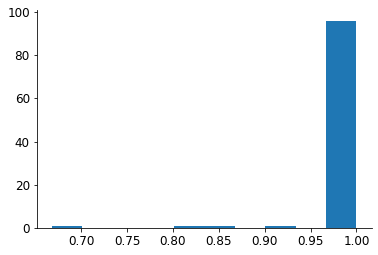

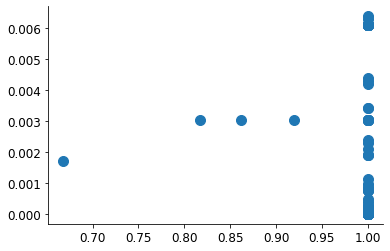

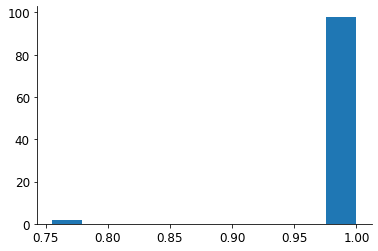

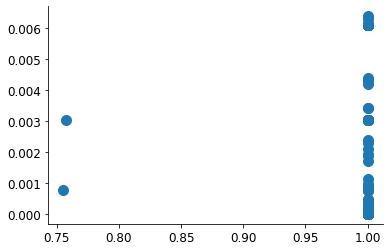

In [35]:
W = load_W().numpy()
W_E = W[0,0,:]

def ISN_coeff(z):
    h = z[:,:4]
    dh = z[:,4:]

    r_ts = V1_sim(h, 0.*dh)
    r_ss = r_ts[:,:,-1].numpy()
    h_E = h[:,0]
    u_E = np.dot(W_E, r_ss.T) + h_E
    u_E[u_E < 0.] = 0.
    ISN_coeff1 = 1.-2*(u_E)*W_E[0]
    
    r_ts = V1_sim(h, dh)
    r_ss = r_ts[:,:,-1].numpy()
    h_E = h[:,0] + dh[:,0]
    u_E = np.dot(W_E, r_ss.T) + h_E
    u_E[u_E < 0.] = 0.
    ISN_coeff2 = 1.-2*(u_E)*W_E[0]
    
    return ISN_coeff1, ISN_coeff2

ISN_coeff1, ISN_coeff2 = ISN_coeff(z)

plt.figure()
plt.hist(ISN_coeff1)
plt.show()
plt.figure()
plt.scatter(ISN_coeff1, T_x[:,2])
plt.show()

plt.figure()
plt.hist(ISN_coeff2)
plt.show()
plt.figure()
plt.scatter(ISN_coeff2, T_x[:,2])
plt.show()

In [26]:
def plot_sims(z, sigma_eps=0.05, gamma_lims=(-1,2), M=200, subscript=None, fontsize=14):
    h = z[:4][None,:]
    dh = z[4:][None,:]


    _h = np.tile(h, [M, 1])
    _dh = np.tile(dh, [M, 1])
    r_ts = []
    gammas = np.concatenate((np.array([0,1,]), np.linspace(gamma_lims[0], gamma_lims[1], 21)))
    for gamma in gammas:
        r_ts.append(V1_sim(_h, gamma*_dh))
    r_ts = np.array(r_ts)
    mean_r_ts = np.mean(r_ts, axis=1)
    std_r_ts = np.std(r_ts, axis=1)

    t = 0.005*np.arange(101)
    fig, axs = plt.subplots(1,3, figsize=(12,4))

    for i in range(4):
        axs[0].plot(t, mean_r_ts[0,i,:], c=colors[i])
        axs[0].fill_between(t, 
                            mean_r_ts[0,i,:]-std_r_ts[0,i,:],
                            mean_r_ts[0,i,:]+std_r_ts[0,i,:],
                            facecolor=colors[i], alpha=0.5)

        axs[1].plot(t, mean_r_ts[1,i,:], c=colors[i])
        axs[1].fill_between(t, 
                            mean_r_ts[1,i,:]-std_r_ts[1,i,:],
                            mean_r_ts[1,i,:]+std_r_ts[1,i,:],
                            facecolor=colors[i], alpha=0.5)

        axs[2].plot(gammas[2:], mean_r_ts[2:,i,-1], c=colors[i])
        axs[2].fill_between(gammas[2:], 
                            mean_r_ts[2:,i,-1]-std_r_ts[2:,i,-1],
                            mean_r_ts[2:,i,-1]+std_r_ts[2:,i,-1],
                            facecolor=colors[i], alpha=0.5)
        
    axs[0].set_xlabel(r'$t$ (s)', fontsize=fontsize)
    axs[0].set_ylabel(r'$r(t)$', fontsize=fontsize)
    if subscript is not None:
        axs[0].set_title(r'$b_%d$' % subscript, fontsize=fontsize+4)
    else:
        axs[0].set_title(r'$b$', fontsize=fontsize+4)
    
    axs[1].set_xlabel(r'$t$ (s)', fontsize=fontsize)
    axs[1].set_ylabel(r'$r(t)$', fontsize=fontsize)
    if subscript is not None:
        axs[1].set_title(r'$b_%d + dh^{(c)}_%d$' % (subscript, subscript), fontsize=fontsize+4)
    else:
        axs[1].set_title(r'$b + dh^{(c)}$', fontsize=fontsize+4)
    
    axs[2].set_xlabel(r"$c \propto $contrast", fontsize=fontsize)
    axs[2].set_ylabel(r'$r_{ss}$', fontsize=fontsize)
    if subscript is not None:
        axs[2].set_title(r'$b_%d + c dh^{(c)}_%d$' % (subscript, subscript), fontsize=fontsize+4)
    else:
        axs[2].set_title(r'$b + dh^{(c)}$', fontsize=fontsize+4)

    return gammas[2:], mean_r_ts[2:], std_r_ts[2:]

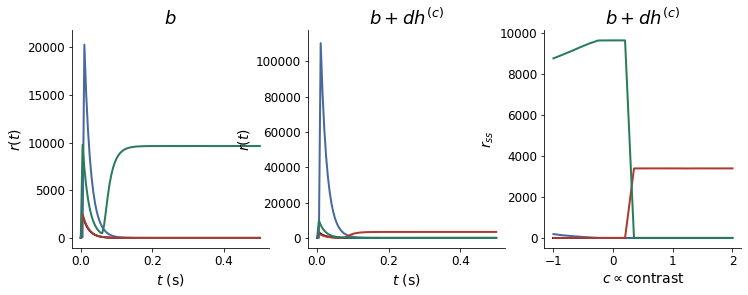

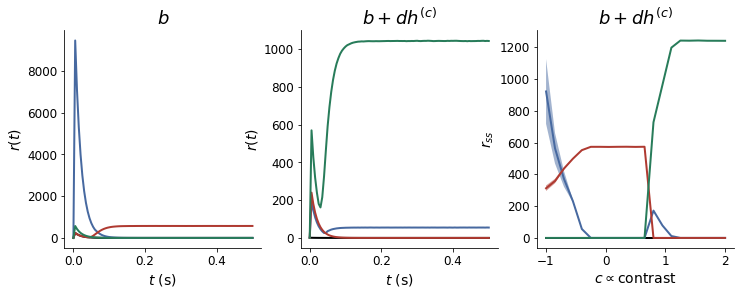

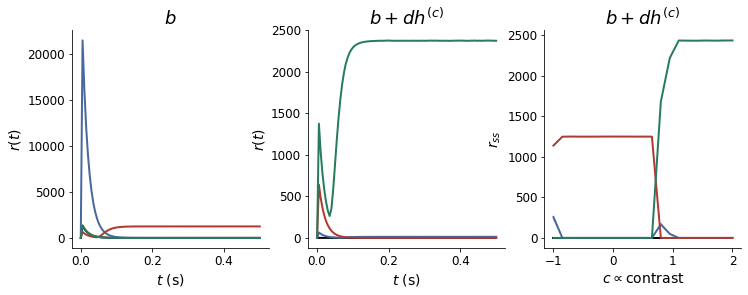

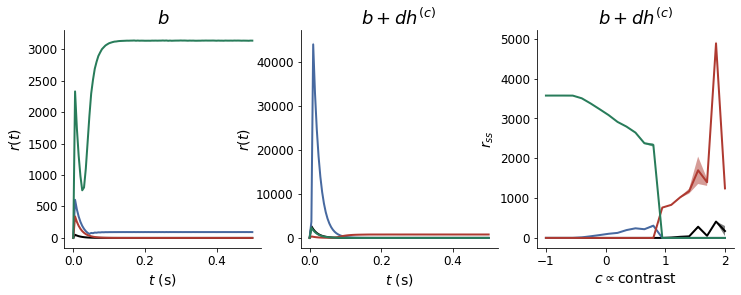

In [27]:
ISN_coeff1 = ISN_coeff(z)
for i in range(4):
    gamma = ISN_coeff1[0][i]
    _x, _y, _z = plot_sims(z[i], M=10)
    plt.show()

In [65]:
T_x_sim = model.eps(z).numpy()

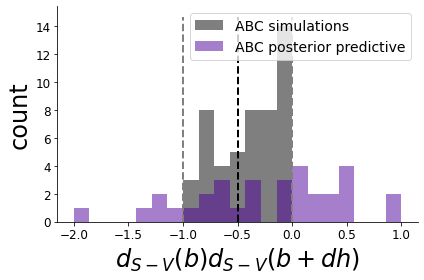

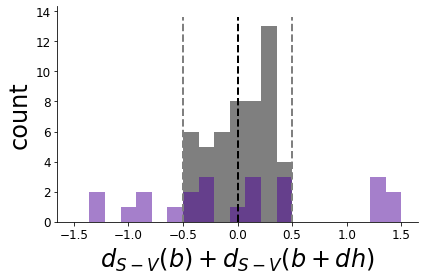

In [66]:
from epi.util import plot_T_x 

nbins=21
xmins = [-2, -1.5]
xmaxs = [1, 1.5]
xlabels = [r"$d_{S-V}(b)d_{S-V}(b+dh)$",
           r"$d_{S-V}(b) + d_{S-V}(b+dh)$"]

if diff_prod_mean == -0.25:
    mu = np.array([-0.25, 0.0, 0.125**2, 0.125**2])
else:
    mu = np.array([-0.5, 0.0, 0.25**2, 0.25**2])

for i in range(2):
    ax = plot_T_x(T_x[:,i], T_x_sim[:,i], bins=nbins, 
                 x_mean=mu[i], x_std=np.sqrt(mu[i+2]),
                 xmin=xmins[i], xmax=xmaxs[i], 
                 xlabel=xlabels[i], ylim=None, fontsize=24)
    if i==0:
        plt.legend()
    plt.tight_layout()
    plt.savefig(figdir + 'SVflip_ABC_Tx%d.png' % (i+1))

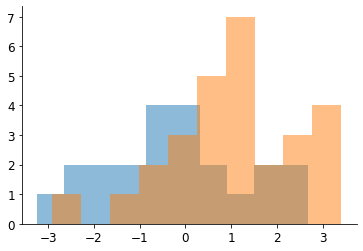

In [67]:
h = z[:,:4]
dh = z[:,4:6]
r_t1s = []
r_t2s = []
r_t1s = V1_sim(h, 0.*dh, sigma_eps)
r_t2s = V1_sim(h, dh, sigma_eps)
   
SV_diff = (r_t2s[:,2,-1] - r_t2s[:,3,-1]).numpy()

plt.figure()
plt.hist(SV_diff[dh[:,0] < 0.], alpha=0.5)
plt.hist(SV_diff[dh[:,0] >= 0.], alpha=0.5)
plt.show()

In [16]:
print(ISN_coeff1)

tf.Tensor(
[0.921819   0.96570295 0.74251354 0.8299889  0.90428436 0.9702072
 0.8456417  0.7336151  0.7536756  0.83876    0.74727404 0.85782605
 0.8046406  0.7288333  0.74028355 0.7518467  0.8368466  0.8829727
 0.77794373 0.9087436  0.92498356 0.8670714  0.9708686  0.8506133
 0.8187017  0.8653673  0.7503524  0.74199384 0.83798873 0.7140934
 0.8539057  0.8897006  0.865613   0.765869   0.7344345  0.7288065
 0.8749414  0.8166659  0.8470926  0.8656316  0.7991705  0.8961263
 0.9952131  0.95385444 0.9697698  0.8568087  0.97367656 0.81040835
 0.7933664  0.9373492  0.8480666  0.8654602  1.         0.81834406
 0.7431917  0.79922545 0.7756405  0.8292779  0.9585234  1.
 0.9412895  0.73920923 0.9915273  0.86587393 0.94872886 0.8686857
 0.9447982  0.81728554 0.80901027 0.88907635 0.8128012  0.95420444
 0.8937296  0.76339835 0.73444927 0.96758825 0.9434316  0.8300069
 0.9009419  0.9542855  0.81928086 0.91069716 0.7258713  0.78884006
 0.73565686 0.96225476 0.7919579  0.7725288  0.7914276  0.9507474
 

In [74]:
M = 1000
num_keep = 1000

mean = [0.]
std = [0.1]

def accept_inds(T_x, mean ,std):
    return np.logical_and(mean[0]-2*std[0] < T_x[:,0], T_x[:,0] < mean[0]+2*std[0])

num_found = 0
z = None
T_x = None
x = []
while (num_found < num_keep):
    _z = np.zeros((M, D))
    for j in range(D):
        _z[:,j] = np.random.uniform(lb[j], ub[j], (M,))
    #_T_x = model.eps(_z).numpy()
    _T_x = ISN_coeff(_z)
    _T_x_stable = V1_sim_stable(_z[:,:4], 0.*_z[:,4:6], sigma_eps).numpy()

    inds = accept_inds(_T_x, mean, std)
    _z = _z[inds, :]
    _T_x = _T_x[inds, :]
    _f_norm = _T_x_stable[inds,4]
    num_found += _z.shape[0]

    if (z is None):
        z = _z
        T_x = _T_x
        f_norm = _f_norm
    else:
        z = np.concatenate((z, _z), axis=0)
        T_x = np.concatenate((T_x, _T_x), axis=0)
        f_norm = np.concatenate((f_norm, _f_norm), axis=0)
    print('%d/%d\r' % (num_found, num_keep), end='')
    x.append(num_found)

num_found = z.shape[0]

# reduce to num_keep
z = z[:num_keep]
T_x = T_x[:num_keep]
f_norm = f_norm[:num_keep]



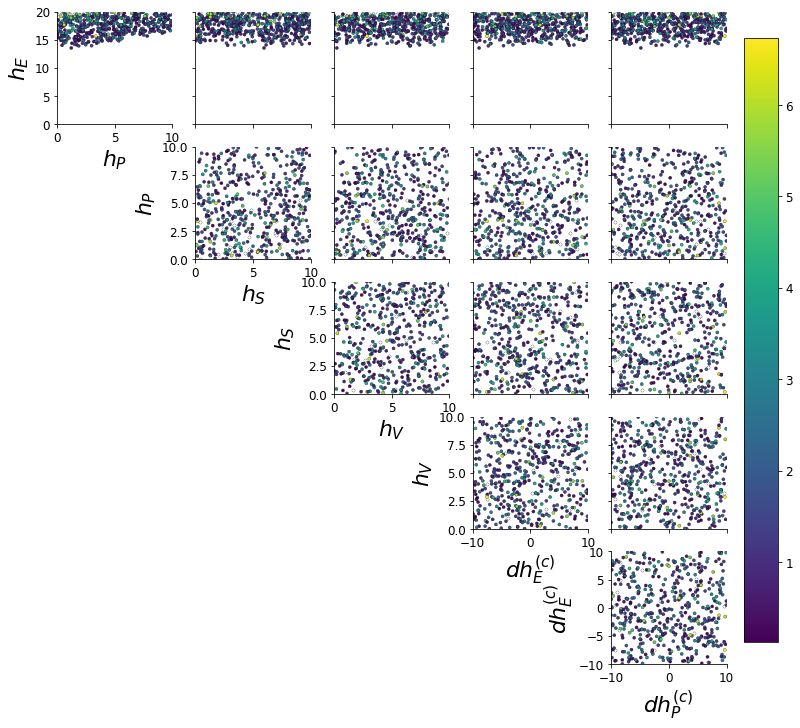

In [75]:
num_plot = 500
fontsize = 14
z_labels = [r'$h_E$', r'$h_P$', r'$h_S$', r'$h_V$', r'$dh^{(c)}_E$', r'$dh^{(c)}_P$', 'n', r'$\epsilon$']
fig = pairplot(z[:num_plot], np.arange(6), z_labels,
               fontsize=22, outlier_stds=2,
               lb=lb, ub=ub,
               c = f_norm)
plt.savefig(figdir + 'SV_flip_ABC_z.png')
               #c_label='prod')